In [ ]:
!pip install gym_minigrid
!pip install stable_baselines3

In [ ]:
from gym_minigrid.wrappers import *
from gym_minigrid.minigrid import *
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib notebook

# Create custom enviroment

Environment where ball and agent are randomly put into square grid. Ball color and grid size can be changed.

In [311]:
class EmptyBallRoom(MiniGridEnv):
    def __init__(self, size=5, ball_color="green"):
        self.ball_color = ball_color
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True
    

        return obs, reward, done, info

In [145]:
# Function to create the environment (needed for vectorized environment object in training process)
def make_env(ball_color, room_size, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = ImgObsWrapper(RGBImgPartialObsWrapper(EmptyBallRoom(size=16, ball_color=ball_color)))
        #env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [127]:
BALL_COLOR = "green"
ROOM_SIZE = 16

# Reinforcment learning

### Training first agent (not essential to use the trained agent)

In [ ]:
# Number of "cores" to use
N_CPU = 12

In [ ]:
# Create vectorized environment to make learning faster
env = SubprocVecEnv([make_env(ball_color = BALL_COLOR, room_size=ROOM_SIZE, rank=i*2) for i in range(N_CPU)])

In [ ]:
# Activation function to be used in CNN layers
policy_kwargs = dict(activation_fn=nn.ReLU)

In [ ]:
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html?highlight=PPO
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=1)

In [ ]:
model.learn(total_timesteps=2_500_000)

In [ ]:
model.save("rgb_ball_agent")

### Loading trained agent

In [584]:
# To load zip file just enter the file name without the file type in the end
model = PPO.load("rgb_ball_agent", device="cpu")

# Displaying the agent in the enivronment

In [585]:
def display_agent(env,  pov="agent", n_eval=10):
    # Two picturs. Left side = agent's view, right side = whoel environment
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10, 5));

    for i in range(n_eval):
        state = env.reset()
        if i == 0:
            image1 = ax1.imshow(state)              
            image2 = ax2.imshow(env.render("rgb_array"))
            
        else:
            image1.set_data(state)
            image2.set_data(env.render("rgb_array"))
        while True:
            #transformed_state = DoReplaceRwG(state)
            action, _ = model.predict(state)
            state, r, done, _ = env.step(action)
            image1.set_data(state)
            image2.set_data(env.render("rgb_array"))
    
            ax1.set_title(f"Action = {action}")
            ax2.set_title(f"Action = {action}")
            fig.canvas.draw()
            if done:
                break

In [160]:
import cv2

def DoReplaceRwG(env):
    
    img = env
    env_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #Define range for green color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])
    mask = cv2.inRange(env_hsv, lower_blue, upper_blue)
    env_hsv[mask != 0] = [70,255,255] # make blue green
    img_transformed = cv2.cvtColor(env_hsv, cv2.COLOR_HSV2RGB) #covert back to RGB
    env_transformed = env
    env_transformed = img_transformed
    return env_transformed


In [586]:
# Make testing environment. Don't use previous vectorized environment (for me it freezed the notebook)
test_env = make_env(ball_color = "blue", room_size=20, rank=5)()

<IPython.core.display.Javascript object>


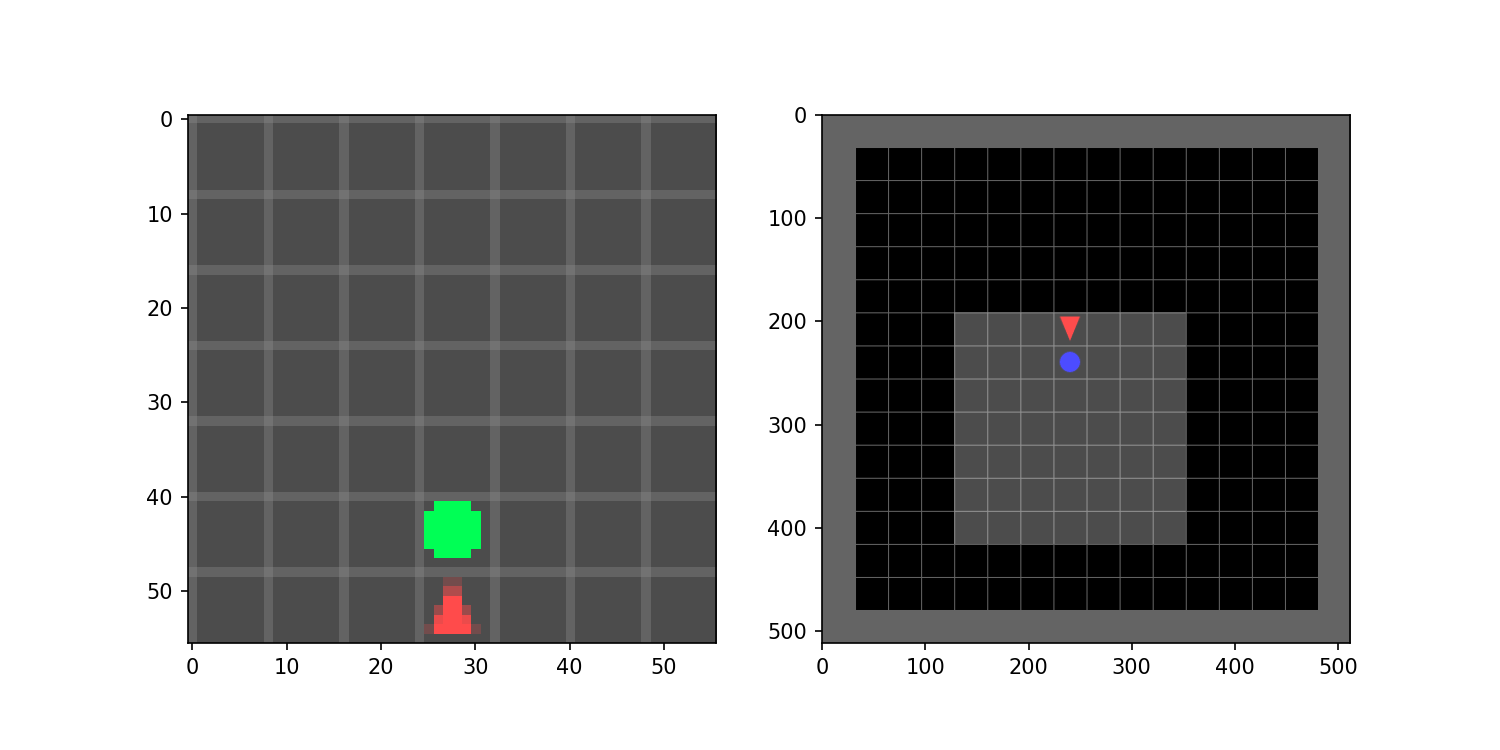

In [587]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
state = test_env.reset()
transformed_state = DoReplaceRwG(state)
image1 = ax1.imshow(transformed_state)  
image2 = ax2.imshow(test_env.render("rgb_array"))
fig.show()

action, _ = model.predict(state)
state, r, done, s = test_env.step(action)

<IPython.core.display.Javascript object>


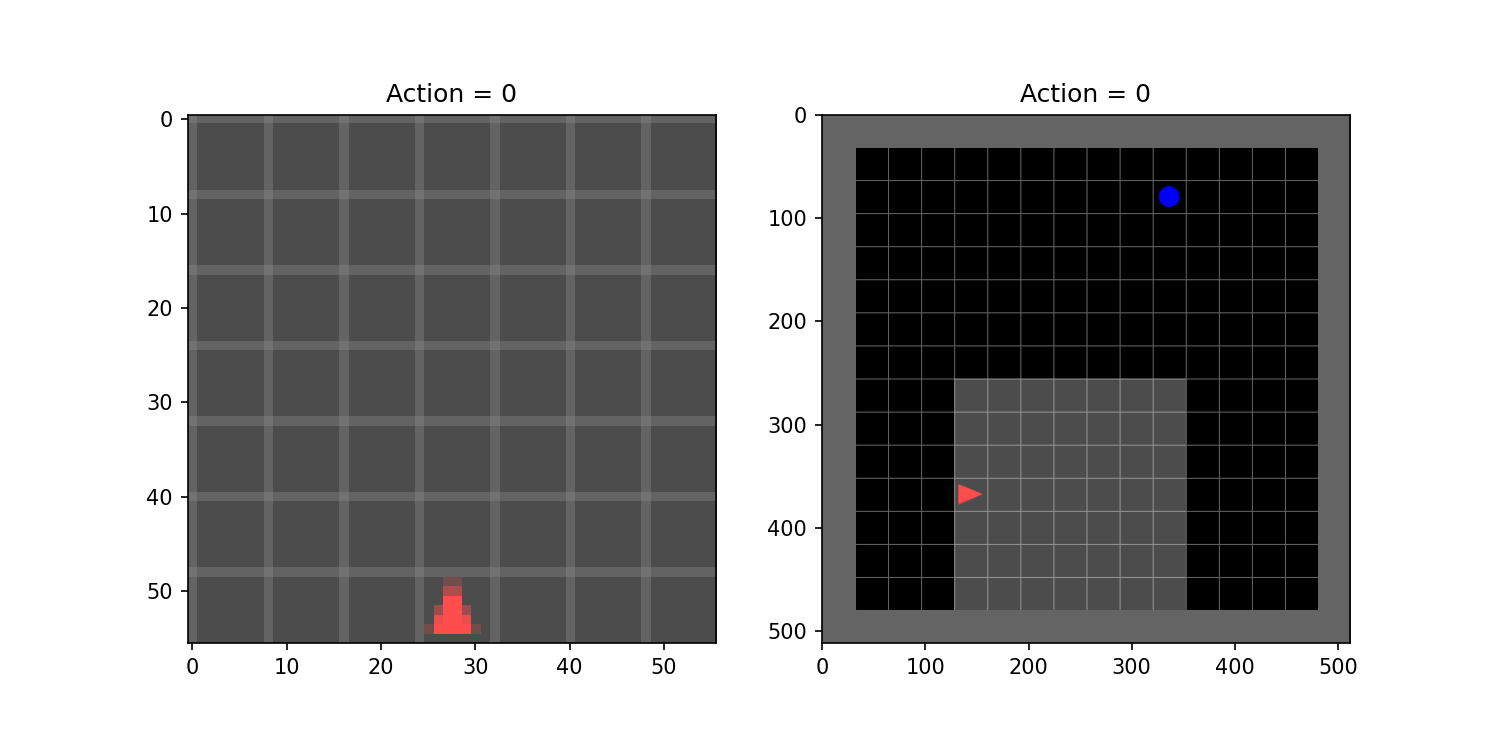

KeyboardInterrupt: 

In [588]:
%matplotlib notebook
display_agent(test_env)

# 2nd agent

This requires to change our environment. Because stable_baselines3 gets the action indeices from the environment. Look at:
https://github.com/maximecb/gym-minigrid/blob/1d4edcfd585f6b627ebf1cfd54ea5e70260fa1ee/gym_minigrid/minigrid.py#L629

https://github.com/maximecb/gym-minigrid/blob/1d4edcfd585f6b627ebf1cfd54ea5e70260fa1ee/gym_minigrid/minigrid.py#L1099
I think redefining the Actions class and step function should be sufficient.
Possible way is to inherit EmptyBallRoom class because it has correct reward function.

In [564]:
from gym import spaces

class  EmptyBallTransformedRoom(gym.Env):
    metadata = {'render.modes': ['human','rgb_array','rgb_array_orig','rgb_array_orig_obs']}
    N_DISCRETE_ACTIONS = 2
    HEIGHT = 64
    WIDTH = 64
    N_CHANNELS = 3

    #actions
    nothing = 0
    replaceRwG = 1
    def __init__(self):
        super(EmptyBallTransformedRoom, self).__init__()
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Example for using image as input:
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        #initialize existing environment. Should be moved to input
        self.existing_env = ImgObsWrapper(RGBImgPartialObsWrapper(EmptyBallRoom(size=16, ball_color='blue')))
        self.existing_env_action = None
        self.state = None
        self.existing_env_state = None
        
        #initialize existing agent. Should be moved to input
        self.existing_agent_model = PPO.load("rgb_ball_agent", device="cpu")
        
    def reset(self):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        self.state = self.existing_env.reset()
        self.existing_env_state = self.state
        return self.state.astype(np.uint8)
    def render(self, mode='human', close=False):
            # Render the environment to the screen
            im = self.state     
            if mode =='human':
                plt.imshow(self.existing_env.render("rgb_array"))
                plt.axis('off')            
            elif mode == 'rgb_array_orig':
                return self.existing_env.render("rgb_array") #original evironment 
            elif mode == 'rgb_array_orig_obs':
                return self.existing_env_state #original environment obs
            elif mode == 'rgb_array':
                return self.state #current obs
    
    def step(self, action):

        if action == self.replaceRwG:
            self.state = DoReplaceRwG(self.state)
        elif action == self.nothing:
            None
        else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        self.initial_env_action, _ = self.existing_agent_model.predict(self.state)
        
        self.existing_env_state = self.state
        state, reward, done, _ = self.existing_env.step(self.initial_env_action)
        self.state = state
        
        info = {}

        return self.state.astype(np.uint8), reward, done, info

        
        
    

In [565]:

from stable_baselines3.common.env_checker import check_env

env = EmptyBallTransformedRoom()
# It will check your custom environment and output additional warnings if needed
check_env(env)

In [569]:
#Sanity check. Always replace color
env = EmptyBallTransformedRoom()

obs = env.reset()
#print(env.observation_space)
#print(env.action_space)
#print(env.action_space.sample())

replaceRwG = 1
n_steps = 40
for step in range(n_steps):
    print("Step {}".format(step + 1))
    obs, reward, done, info = env.step(replaceRwG)
    print('obs sum', np.sum(obs), 'reward=', reward, 'done=', done)
    if done:
        print("Goal reached!", "reward=", reward)
        break

Step 1
obs sum 770548 reward= 0 done= False
Step 2
obs sum 770548 reward= 0 done= False
Step 3
obs sum 770548 reward= 0 done= False
Step 4
obs sum 770548 reward= 0 done= False
Step 5
obs sum 770548 reward= 0 done= False
Step 6
obs sum 770548 reward= 0 done= False
Step 7
obs sum 857068 reward= 0 done= False
Step 8
obs sum 770548 reward= 0 done= False
Step 9
obs sum 857068 reward= 0 done= False
Step 10
obs sum 770548 reward= 0 done= False
Step 11
obs sum 770548 reward= 0 done= False
Step 12
obs sum 770548 reward= 0 done= False
Step 13
obs sum 857068 reward= 0 done= False
Step 14
obs sum 943588 reward= 0 done= False
Step 15
obs sum 1030108 reward= 0 done= False
Step 16
obs sum 770548 reward= 0 done= False
Step 17
obs sum 773956 reward= 0 done= False
Step 18
obs sum 773956 reward= 0 done= False
Step 19
obs sum 860476 reward= 0 done= False
Step 20
obs sum 946996 reward= 0 done= False
Step 21
obs sum 1033516 reward= 0 done= False
Step 22
obs sum 1120036 reward= 0 done= False
Step 23
obs sum 

In [589]:
from stable_baselines3.common.cmd_util import make_vec_env

# Instantiate the env
env = EmptyBallTransformedRoom()
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

In [590]:
model_hack = PPO('CnnPolicy', env, verbose=1).learn(10000)

Using cpu device
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 61.9     |
|    ep_rew_mean     | 0.946    |
| time/              |          |
|    fps             | 155      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 63.1        |
|    ep_rew_mean          | 0.945       |
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2           |
|    time_elapsed         | 38          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017953118 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.677      |
|    explained

In [591]:
model_hack.save("rgb_ball_color_change_agent")

In [592]:
# Instantiate the env again
env = EmptyBallTransformedRoom()
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

In [593]:
model = PPO.load("rgb_ball_color_change_agent", device="cpu")

In [594]:
def display_agent_hacked(env,  pov="agent", n_eval=10, model=None):
    # Two picturs. Left side = agent's view, right side = whoel environment
    fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5));

    for i in range(n_eval):
        state = env.reset()
        if i == 0:
            image1 = ax1.imshow(np.array(state)[0])              
            image2 = ax2.imshow(env.render("rgb_array_orig_obs"))
            image3 = ax3.imshow(env.render("rgb_array_orig"))
            
        else:
            image1.set_data(np.array(state)[0])
            image2.set_data(env.render(mode="rgb_array_orig_obs"))
            image3.set_data(env.render(mode="rgb_array_orig"))
        while True:
            action, _ = model.predict(state)
            state, r, done, _ = env.step(action)
            image1.set_data(np.array(state)[0])
            image2.set_data(env.render(mode="rgb_array_orig_obs"))
            image3.set_data(env.render(mode="rgb_array_orig"))
     
            ax1.set_title(f"Original obs: Action = {env.get_attr('initial_env_action')}")
            ax2.set_title(f"Hacked obs: Action = {action}")
            ax3.set_title(f"Initial environment, Reward = {r}, \n Done = {done}")
            
            fig.canvas.draw()
            if done:
                break

<IPython.core.display.Javascript object>


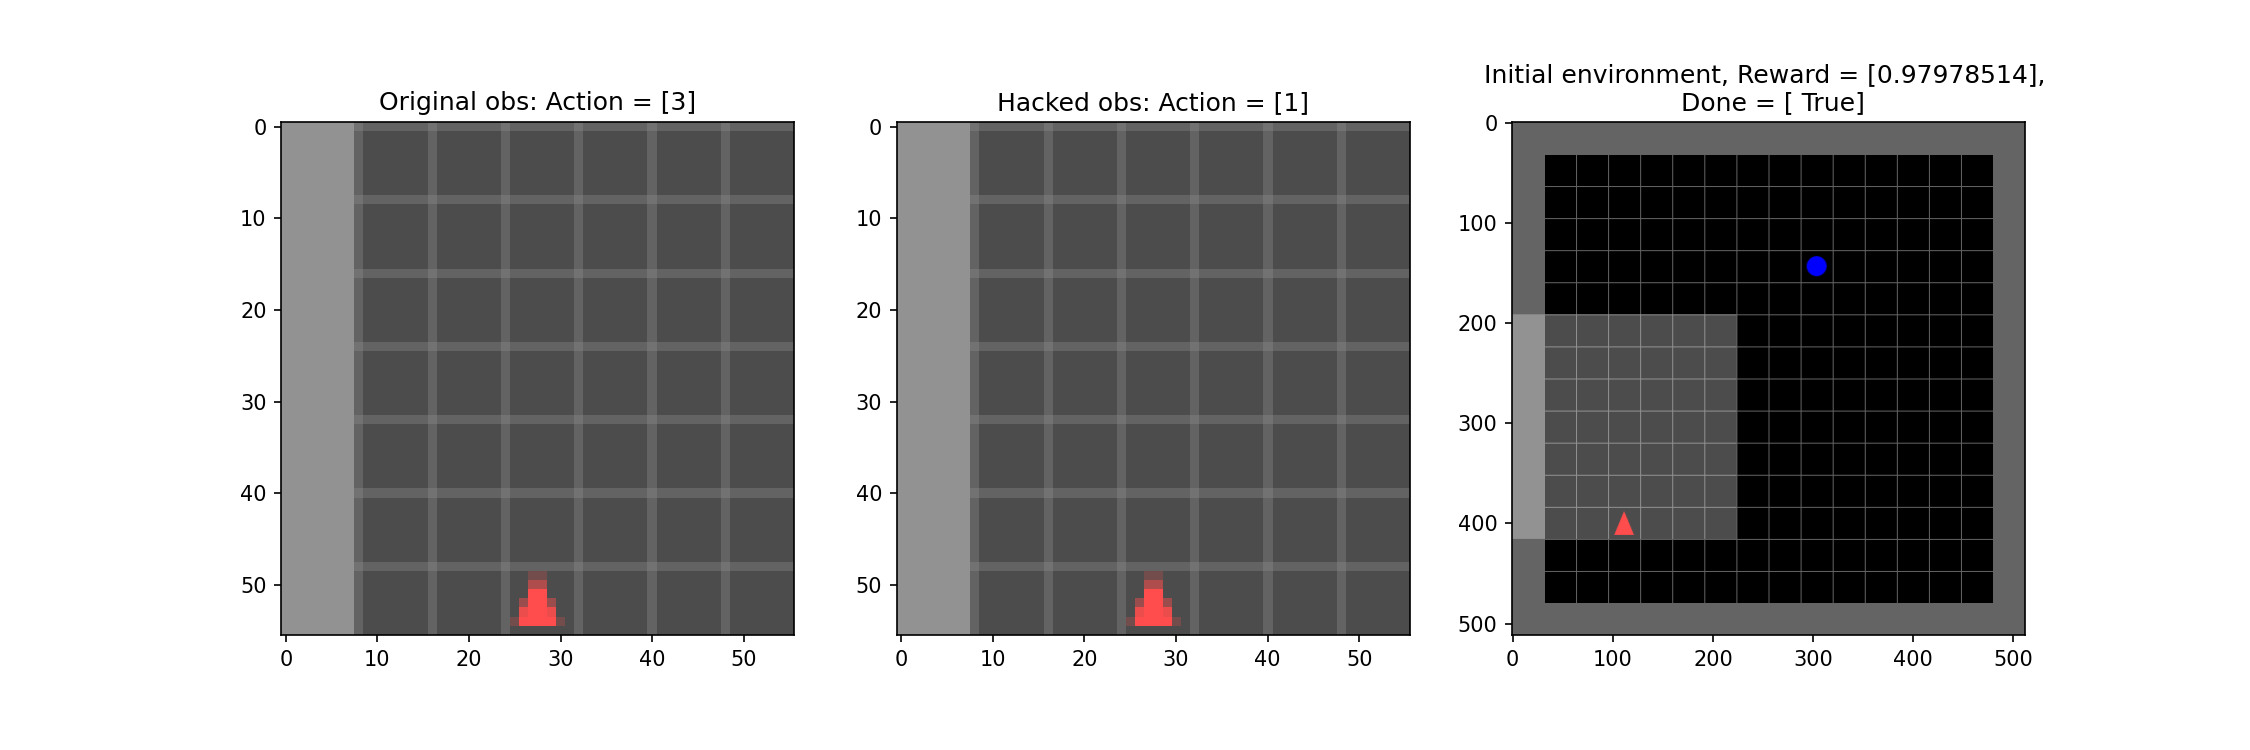

In [595]:
display_agent_hacked(env, model=model)